c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\matrix_elements_Pocklington.py:50: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Z_1 = integrate.quad(ReZGreen_function, r_n[2]-dz/2, r_n[2]+dz/2)[0] + 1j * integrate.quad(ImZGreen_function, r_n[2]-dz/2, r_n[2]+dz/2)[0]
c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\matrix_elements_Pocklington.py:50: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Z_1 = integrate.quad(ReZGreen_function, r_n[2]-dz/2, r_n[2]+dz/2)[0] + 1j * integrate.quad(ImZGreen_function, r_n[2]-dz/2, r

[4 3] 2


TypeError: only integer scalar arrays can be converted to a scalar index

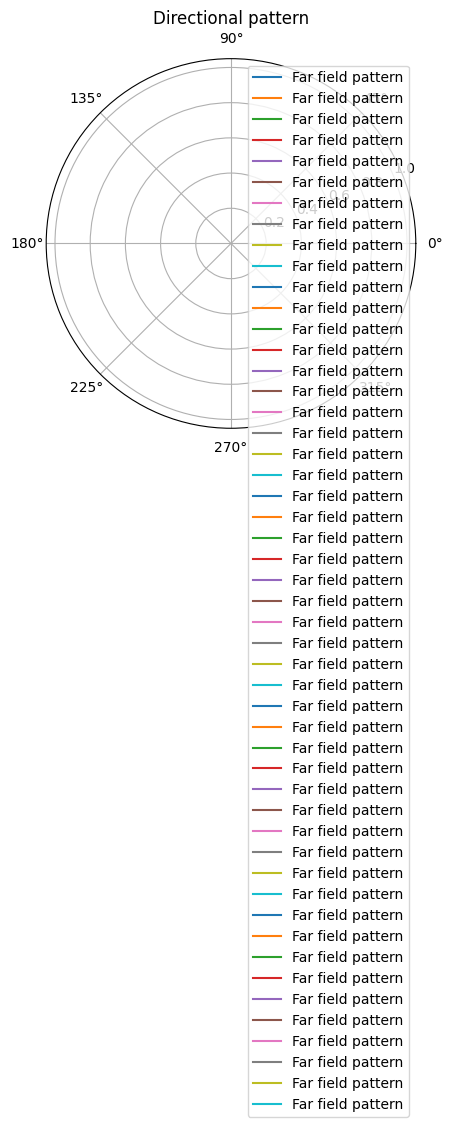

In [81]:
from solver_for_Pocklington_equation import directional_pattern
import numpy as np
import random

#* Define constants
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

phi = np.linspace(1e-6, 2*np.pi - 1e-6, 1000)
target_pattern = np.array(np.maximum(0, np.sin(np.pi / 2 + phi)) ** 7)

frequency = 146e6
delta_z, incident_voltage = light_speed / 2 * np.pi * frequency / 1e2, 10
wavelength = light_speed / frequency
# Генерация диаграммы направленности антенны
def antenna_pattern(parent):
    element_position, element_length, wire_radius, source_position = parent
    return directional_pattern(frequency, delta_z, incident_voltage, element_position, element_length, wire_radius, source_position)[7]

# Инициализация популяции
def initialize_population(population_size, num):    
    return [
        [
            (position := np.random.rand(num, 3) * wavelength),  # Позиции
            np.random.rand(num) * wavelength,                   # Длины
            np.full(num, 3.175e-3),                             # Радиусы провода
            position[np.random.randint(num)]                    # Случайная позиция источника
        ]
        for _ in range(population_size)
    ]

# Оценка приспособленности
def fitness(parent):
    return np.dot(antenna_pattern(parent), target_pattern) / np.linalg.norm(antenna_pattern(parent)) / np.linalg.norm(target_pattern)# Скалярное произведение

# Отбор родителей
def select_parents(population):
    fitness_scores = [fitness(length) for length in population]
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Сортировка по убыванию
    print(sorted_indices[:len(population) // 2], len(population) // 2)
    return population[sorted_indices[:len(population) // 2]]

# Скрещивание родителей
def crossover(parent1, parent2):
    return (parent1[1] + parent2[1]) / 2  # Скрещивание двух длин

# Мутация потомства
def mutate(length, mutation_rate):
    if random.random() < mutation_rate:
        return length[1] + np.random.normal(0, 0.1)  # Небольшое изменение длины
    return length[1]

# Основная функция оптимизации
def hybrid_optimizer(num, population_size, generations, mutation_rate):
   
    # Инициализация популяции и скоростей
    population = initialize_population(population_size, num)
    velocities = np.random.rand(population_size) * 10  # Начальные скорости
    personal_bests = population.copy()

    best_global = max(population, key=lambda length: fitness(length))

    for generation in range(generations):
        
        # Обновление личных лучших значений
        for i in range(len(population)):
            if fitness(population[i]) > fitness(personal_bests[i]):
                personal_bests[i] = population[i]

        # Обновление глобального лучшего значения
        best_global = max(best_global, max(population, key=lambda length: fitness(length)))

        # Отбор родителей и создание нового поколения
        parents = select_parents(population)
        next_generation = []

        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(parents.tolist(), 2)
            child_length = crossover(parent1, parent2)
            child_length = mutate(child_length, mutation_rate)
            next_generation.append(child_length)

        population = np.array(next_generation)

    best_length_index = np.argmax([fitness(length, phi, target_pattern) for length in population])
    return population[best_length_index]

# Параметры алгоритма
population_size = 5
generations = 2
mutation_rate = 0.1
num = 1

# Запуск смешанного алгоритма
best_length = hybrid_optimizer(num, population_size, generations, mutation_rate)

print("Лучшие длина антенны:", best_length)


Generation 1: Best Fitness = nan
Лучшие параметры антенны: [array([[0.32867521, 1.87497706, 0.60053193]]), array([1.52155211]), array([0.003175]), array([0.60471652, 1.88665341, 0.79029757])]


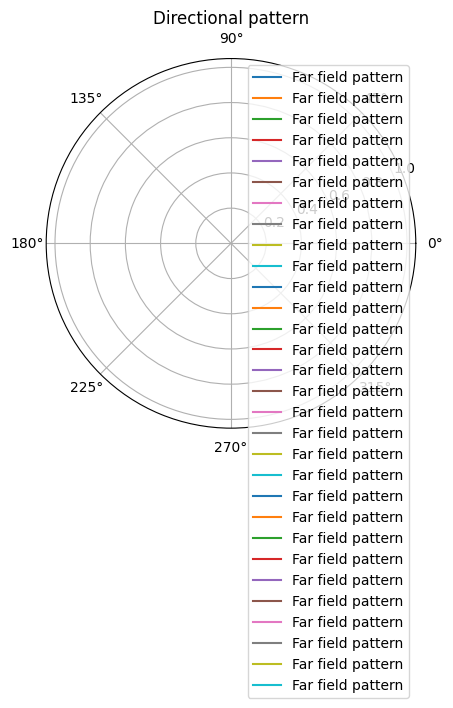

In [107]:
from solver_for_Pocklington_equation import directional_pattern
import numpy as np
import random

#* Define constants
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

phi = np.linspace(1e-6, 2*np.pi - 1e-6, 1000)
target_pattern = np.array(np.maximum(0, np.sin(np.pi / 2 + phi)) ** 7)

frequency = 146e6
delta_z, incident_voltage = light_speed / 2 * np.pi * frequency / 1e2, 10
wavelength = light_speed / frequency

# Заданная функция (например, желаемая диаграмма направленности)
target_pattern = np.array(np.maximum(0, np.sin(np.pi / 2 + phi)) ** 7)

# Генерация диаграммы направленности антенны
def antenna_pattern(position, lengths, wire_radius, source_position):
    return directional_pattern(frequency, delta_z, incident_voltage, position, lengths, wire_radius, source_position)[7]

# Оценка приспособленности
def fitness(individual, phi, target_pattern):
    position, lengths, wire_radius, source_position = individual
    pattern = antenna_pattern(position, lengths, wire_radius, source_position)
    return np.dot(pattern, target_pattern) / np.linalg.norm(target_pattern) / np.linalg.norm(pattern)# Скалярное произведение

# Селекция лучших особей
def select_parents(population, phi, target_pattern):
    fitness_scores = [fitness(individual, phi, target_pattern) for individual in population]
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Сортировка по убыванию
    return [population[i] for i in sorted_indices[:len(population) // 2]]  # Лучшие половина

# Скрещивание двух родителей
def crossover(parent1, parent2):
    position1, lengths1, wire_radius1, source_position1 = parent1
    position2, lengths2, wire_radius2, source_position2 = parent2
    
    child_position = (position1 + position2) / 2
    child_lengths = (lengths1 + lengths2) / 2
    child_wire_radius = wire_radius1  # Радиус провода остается неизменным
    index = np.random.randint(2)
    child_source_position = source_position1 if index == 1 else source_position2  # Случайный выбор источника
    return [child_position, child_lengths, child_wire_radius, child_source_position]

# Мутация потомства
def mutate(individual, mutation_rate):
    position, lengths, wire_radius, source_position = individual
    
    if np.random.rand() < mutation_rate:
        position += np.random.normal(0, 0.1, size=position.shape)  # Небольшое изменение позиции
    
    if np.random.rand() < mutation_rate:
        lengths += np.random.normal(0, 0.1 * np.max(lengths))  # Небольшое изменение длины
    
    return [position, lengths, wire_radius, source_position]

# Инициализация популяции
def initialize_population(population_size, num):    
    return [
        [
            (position := np.random.rand(num, 3) * wavelength),  # Позиции
            np.random.rand(num) * wavelength,                   # Длины
            np.full(num, 3.175e-3),                             # Радиусы провода
            position[np.random.randint(num)]                    # Случайная позиция источника
        ]
        for _ in range(population_size)
    ]
    
# Генетический алгоритм оптимизации
def genetic_algorithm(population_size, num_individuals, generations, mutation_rate):
    phi = np.linspace(1e-6, 2 * np.pi - 1e-6, 1000)

    population = initialize_population(population_size, num_individuals)

    for generation in range(generations):
        parents = select_parents(population, phi, target_pattern)
        next_generation = []

        while len(next_generation) < population_size:
            index1, index2 = np.random.randint(len(parents), size = 2)
            parent1, parent2 = parents[index1], parents[index2]
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            next_generation.append(child)

        population = next_generation

        # Вывод информации о текущем поколении
        best_fitness = max(fitness(individual, phi, target_pattern) for individual in population)
        print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

    best_individual_index = np.argmax([fitness(individual, phi, target_pattern) for individual in population])
    return population[best_individual_index]

# Параметры алгоритма
population_size = 10
num_individuals = 1   # Количество антенн в каждом индивидууме
generations = 1
mutation_rate = 0.1

# Запуск генетического алгоритма
best_antenna = genetic_algorithm(population_size, num_individuals, generations, mutation_rate)

print("Лучшие параметры антенны:", best_antenna)


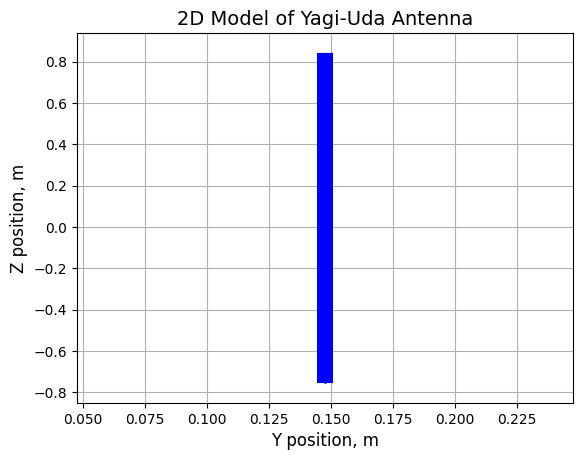

In [159]:
plot_2dmodel(R, np.array(parent[3]), sum(element_num), delta_z)

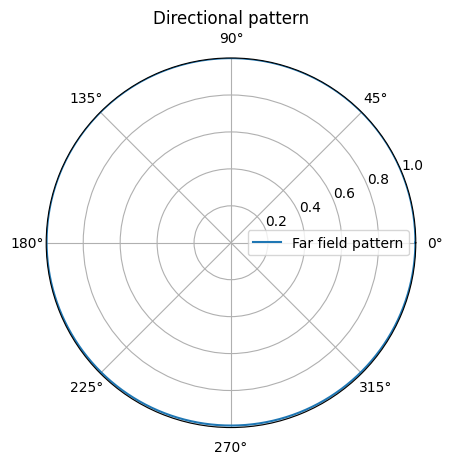

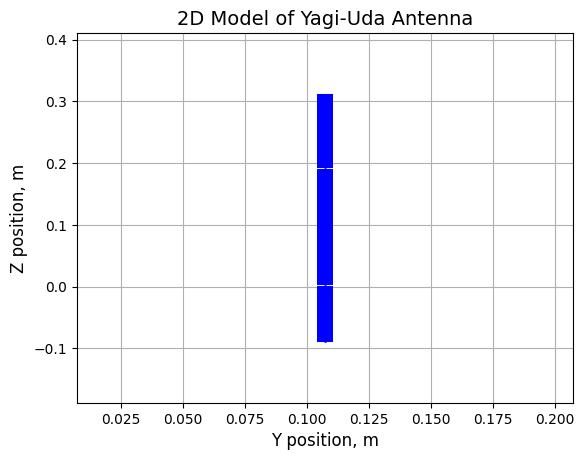

In [165]:
# Инициализация популяции
from visualization import calculate_positions, plot_2dmodel
num = 1
def initialize_population(population_size, num):    
    return [
        [
            (position := np.random.rand(num, 3) * wavelength/10),  # Позиции
            np.random.rand(num) * wavelength,                   # Длины
            np.full(num, 3.175e-3),                             # Радиусы провода
            position[np.random.randint(num)]                    # Случайная позиция источника
        ]
        for _ in range(population_size)
    ]
    
population = initialize_population(population_size, num)
parent = population[0]
#* Define constants
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12
frequency = 1e6 * 146
omega = 2 * np.pi * frequency
incident_voltage = 10

 #* set geometry of antenna
# element_position = np.array([[0,0,0],[0,0.312,0],[0,0.447,0],[0,0.699,0],[0,1.05,0],[0,1.482,0],[0,1.986,0],[0,2.553,0],[0,3.168,0]],dtype=float)
# element_length = np.array([1.038, 0.955, 0.956, 0.932, 0.916, 0.906, 0.897, 0.891, 0.887])
# wire_radius = np.array([3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3])
# source_position = np.array([element_position[1]], dtype = float)

# #! Spatial resolution
delta_z = light_speed / omega / 1e2

R, R_block, element_num, incident_field, impedance, current, current_block, P_total, phi = directional_pattern (frequency, delta_z, incident_voltage, parent[0], parent[1], parent[2], [parent[3]])
plot_2dmodel(R, np.array(parent[3]), sum(element_num), delta_z)